In [305]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [306]:
df = pd.read_csv("../2_Feature_Extraction/extract_features/tracking_features.csv")
df.head()


,tracking_id,num_points,bbox_area,point_density,avg_segment_distance,num_stops
0,59,72,0.001813,39681.685256,104.093826,72
1,65,154,0.006207,24806.119875,103.039632,154
2,78,237,0.046257,5123.419281,153.782723,237
3,87,14,0.002002,6988.110554,508.602238,14
4,172,253,0.000831,304095.272770,50.290536,253


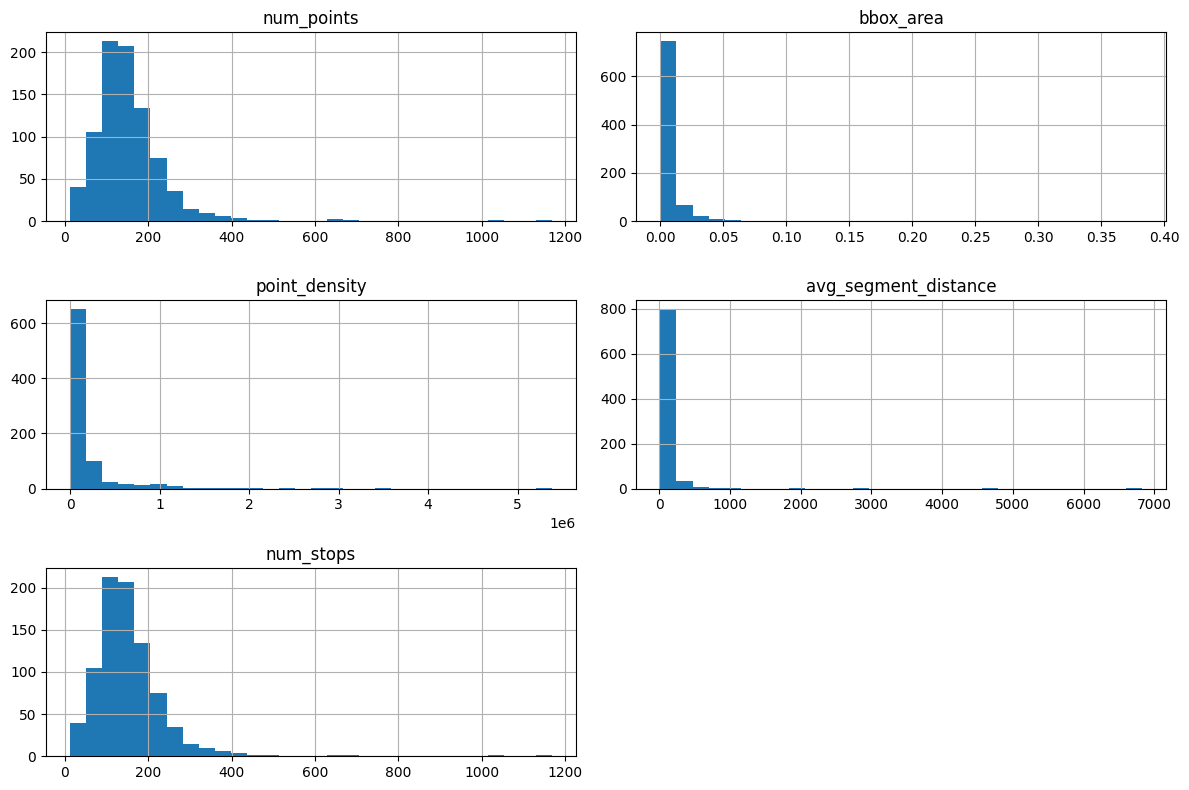

In [307]:
df.drop(columns=["tracking_id"]).hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()


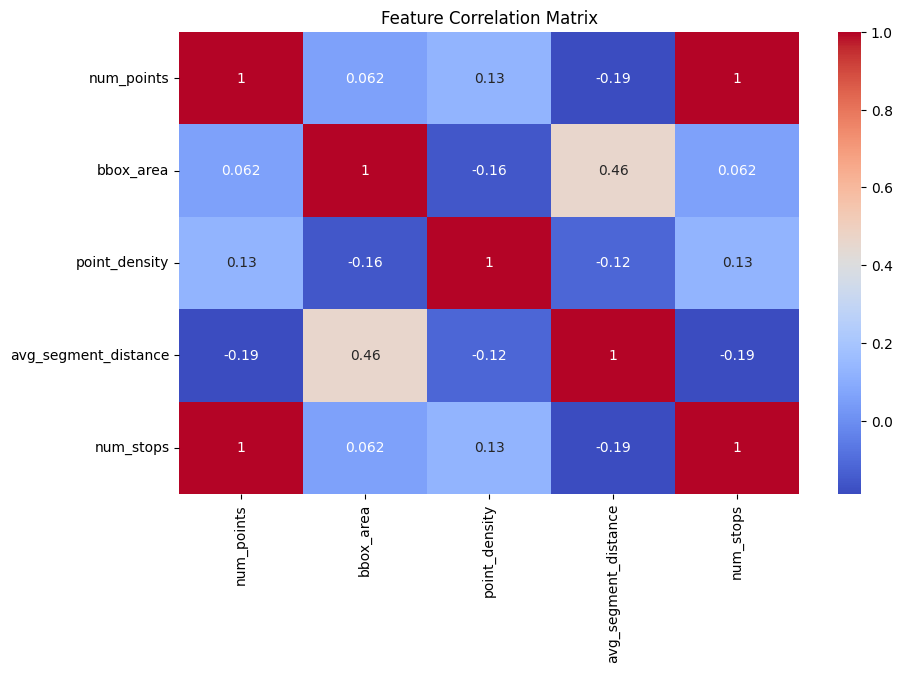

In [308]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.drop(columns=["tracking_id"]).corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


In [309]:
# df = df[(df["avg_segment_distance"] < 1000)]


In [310]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(df.drop(columns=["tracking_id"]))

db = DBSCAN(eps=1, min_samples=40)
df["cluster"] = db.fit_predict(X_scaled)

df.head()


,tracking_id,num_points,bbox_area,point_density,avg_segment_distance,num_stops,cluster
0,59,72,0.001813,39681.685256,104.093826,72,0
1,65,154,0.006207,24806.119875,103.039632,154,0
2,78,237,0.046257,5123.419281,153.782723,237,-1
3,87,14,0.002002,6988.110554,508.602238,14,0
4,172,253,0.000831,304095.272770,50.290536,253,0


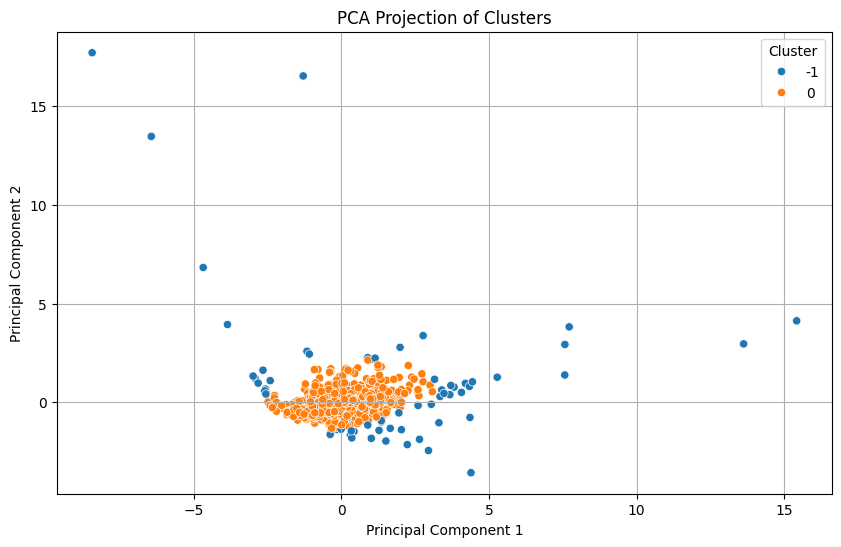

In [311]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df["pca1"] = X_pca[:, 0]
df["pca2"] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="pca1", y="pca2", hue="cluster", palette="tab10")
plt.title("PCA Projection of Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.legend(title="Cluster")
plt.show()


In [312]:
df_clean = df[df["cluster"] != -1].copy()
print(f"Removed {len(df) - len(df_clean)} outliers with DBSCAN")

Removed 63 outliers with DBSCAN


In [313]:
# X = df.drop(columns=["tracking_id"])
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# kmeans = KMeans(n_clusters=4, random_state=42)
# df["cluster"] = kmeans.fit_predict(X_scaled)
print(len(df_clean))

787


In [314]:
from sklearn.cluster import KMeans

X_clean = df_clean.drop(columns=["tracking_id", "cluster"])
X_clean_scaled = StandardScaler().fit_transform(X_clean)

kmeans = KMeans(n_clusters=4, random_state=42)
df_clean["cluster"] = kmeans.fit_predict(X_clean_scaled)

df = df_clean
print(df.head())

   tracking_id  num_points  bbox_area  point_density  avg_segment_distance  \
0           59          72   0.001813   39681.685256            104.093826   
1           65         154   0.006207   24806.119875            103.039632   
3           87          14   0.002002    6988.110554            508.602238   
4          172         253   0.000831  304095.272770             50.290536   
6          438         171   0.000783  218040.167779             79.507189   

   num_stops  cluster      pca1      pca2  
0         72        1 -1.241092 -0.515201  
1        154        1 -0.030022  0.038345  
3         14        2 -2.481341  0.018362  
4        253        0  1.661802 -0.039573  
6        171        0  0.360710 -0.289742  


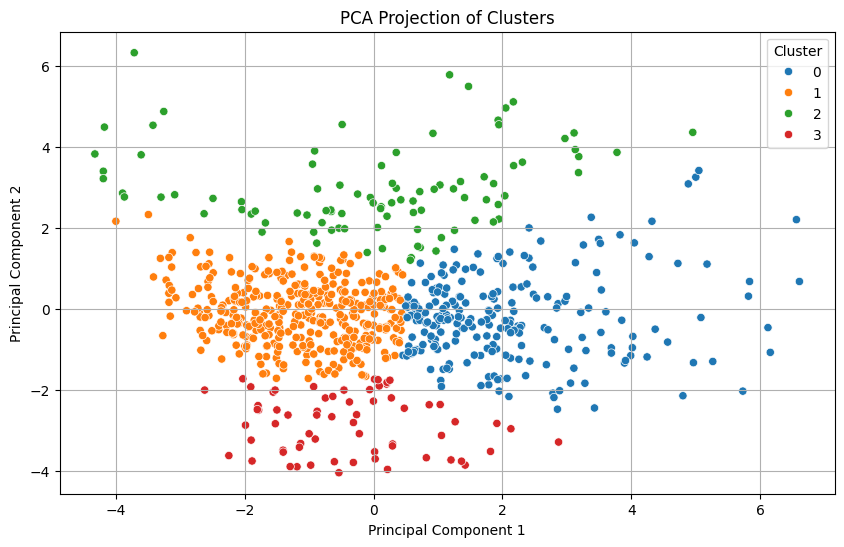

In [315]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clean_scaled)

df["pca1"] = X_pca[:, 0]
df["pca2"] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="pca1", y="pca2", hue="cluster", palette="tab10")
plt.title("PCA Projection of Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.legend(title="Cluster")
plt.show()


In [316]:
df.describe()
df[df['cluster'] == 2].sort_values("point_density").head()

,tracking_id,num_points,bbox_area,point_density,avg_segment_distance,num_stops,cluster,pca1,pca2
15,1231,20,0.008252,2423.283487,637.902329,20,2,-3.710695,6.324293
67,3837,117,0.038844,3011.954428,319.975477,117,2,1.180022,5.779172
476,61260,29,0.009601,3020.193584,477.938583,29,2,-3.252378,4.874595
11,811,123,0.040328,3049.906153,278.233201,123,2,1.473766,5.493681
481,62304,27,0.007619,3543.295536,461.841965,27,2,-3.419700,4.534814


In [317]:
# Summarize feature means by cluster
summary = df.groupby("cluster").mean(numeric_only=True)
summary["count"] = df["cluster"].value_counts().sort_index()
summary


,tracking_id,num_points,bbox_area,point_density,avg_segment_distance,num_stops,pca1,pca2,count
cluster,,,,,,,,,
0,52435.883621,212.267241,0.006678,74773.253560,92.964432,212.267241,2.065520,-0.227114,232
1,50020.623737,110.252525,0.002415,98508.052533,104.359515,110.252525,-1.140491,-0.094736,396
2,25687.956989,118.645161,0.017731,11004.839703,245.984585,118.645161,-0.017892,2.973585,93
3,42994.030303,151.151515,0.000239,715301.544302,49.865378,151.151515,-0.392455,-2.823294,66


In [318]:
N = 20
example_ids = df.groupby("cluster")["tracking_id"].apply(lambda x: x.sample(min(N, len(x)), random_state=42)).explode().tolist()

waypoints = pd.read_parquet("../2_Feature_Extraction/data/filtered_waypoints.parquet")

example_routes = waypoints[waypoints["id_tracking"].isin(example_ids)].copy()


In [ ]:
# import folium
# from folium import Map, PolyLine
# from IPython.display import display

# cluster_colors = ["blue", "orange", "green", "red"]

# for tracking_id in example_ids:
#     route = example_routes[example_routes["id_tracking"] == tracking_id].sort_values(by="sequence")
#     coords = list(zip(route["latitude"], route["longitude"]))
#     cluster_label = df[df["tracking_id"] == tracking_id]["cluster"].values[0]
    
#     m = folium.Map(location=coords[0], zoom_start=13)
#     folium.PolyLine(coords, color=cluster_colors[cluster_label], weight=5).add_to(m)
#     folium.Marker(coords[0], tooltip=f"Tracking {tracking_id} - Cluster {cluster_label}").add_to(m)
#     display(m)

import folium
from folium import Map, PolyLine, Marker
from IPython.display import display

cluster_colors = ["blue", "orange", "green", "red"]

first_route = example_routes[example_routes["id_tracking"] == example_ids[0]].sort_values("sequence")
center = [first_route.iloc[0]["latitude"], first_route.iloc[0]["longitude"]]

m = folium.Map(location=center, zoom_start=12)

for tracking_id in example_ids:
    route = example_routes[example_routes["id_tracking"] == tracking_id].sort_values(by="sequence")
    coords = list(zip(route["latitude"], route["longitude"]))
    cluster_label = df[df["tracking_id"] == tracking_id]["cluster"].values[0]

    folium.PolyLine(coords, color=cluster_colors[cluster_label], weight=4, tooltip=f"Cluster {cluster_label}").add_to(m)
    Marker(coords[0], tooltip=f"Tracking {tracking_id}").add_to(m)

display(m)


In [ ]:
# manually assign labels to clusters depending on point density because it is a good factor as determined in the data analysis

cluster_to_label = {
    0: "TOWN", # Blue
    1: "SUBURBAN", # Orange 
    2: "RURAL", # Green
    3: "URBAN" # Red
}

df["predicted_label"] = df["cluster"].map(cluster_to_label)
df.to_csv("tracking_features_with_labels.csv", index=False)
print("saved predicted labels to csv")


saved predicted labels to csv
